# Imports

In [ ]:
import pandas as pd
import numpy as np
import operator
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# #definindo o path para executar no LOCAL
path = "/home/pedro/projetoDL/dataset/processado/"
log_path_tmp = "/home/pedro/projetoDL/log"
# definindo o path para log com timestamp
log_path = log_path_tmp + "/exp_" + timestamp + ""

In [2]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU está conectada")
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        print(f"Nome da GPU: {gpu.name}")
else:
    print("Não conectado a uma GPU")

2024-12-05 15:12:30.549825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 15:12:30.560429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 15:12:30.563625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 15:12:30.571971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 15:12:31.162392: W tensorflow/compiler/tf2

GPU está conectada
Nome da GPU: /physical_device:GPU:0


I0000 00:00:1733422351.662061   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733422351.681171   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733422351.683611   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Tensorflow version: ", tf.__version__)

import scipy
print(f"SciPy version: {scipy.__version__}")

import scikitplot as skplt
print(f"scikit-plot version: {skplt.__version__}")

GPU is available
Tensorflow version:  2.17.0
SciPy version: 1.11.4
scikit-plot version: 0.3.7


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
#import scikitplot as skplt
import matplotlib.pyplot as plt
from numpy import interp

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.

    Argumento(s):
history -- Objeto retornado pela função fit do keras.

    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.savefig("ks_plot.png")
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

# Carregar data treino

In [55]:
Y = np.load(path + 'Y_train_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_train_NewApproach_Injected_v2.npz')
X = X.f.arr_0

Selecionar os dados do fold 3 (Melhor resultado)

In [56]:
from sklearn.model_selection import KFold
import numpy as np
import os

# Configurar o KFold e selecionar o fold 3
skf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 0

for train_index, val_index in skf.split(X, Y):
    fold_no += 1
    if fold_no == 3:  # Selecionar o fold 3
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = Y[train_index], Y[val_index]
        break



# Verificar os dados
print(f"Tamanho de x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Tamanho de x_val: {x_val.shape}, y_val: {y_val.shape}")
print("Distribuição em y_train:", np.unique(y_train, return_counts=True))
print("Distribuição em y_val:", np.unique(y_val, return_counts=True))

Tamanho de x_train: (514647, 44, 116), y_train: (514647,)
Tamanho de x_val: (128662, 44, 116), y_val: (128662,)
Distribuição em y_train: (array([0, 1]), array([134480, 380167]))
Distribuição em y_val: (array([0, 1]), array([33964, 94698]))


# Carregar o modelo teacher

In [8]:
from tensorflow.keras.models import load_model

load_path_model = "/home/pedro/projetoDL/log/exp_20241103170505/3_fold/fold_n_3_2dconv_fixed.h5"

teacher_model = load_model(load_path_model)

I0000 00:00:1733422354.846883   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733422354.850009   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733422354.852382   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733422354.971224   75944 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Definindo o modelo Student

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.models import clone_model

student_model = Sequential([
    Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(44, 116, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
],
name="student")

student_model.summary()


Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 44, 116, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 44, 116, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 58, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 58, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 58, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       326,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,713 (1.27 MB)

 Trainable params: 331,617 (1.27 MB)

 Non-trainable params: 96 (384.00 B)

Definindo o modelo Student lightweigth

In [42]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense

lightweight_student_model = Sequential([
    # Primeira camada convolucional com menos filtros
    Conv2D(8, kernel_size=3, activation='relu', padding='same', input_shape=(44, 116, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda camada convolucional com menos filtros
    Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten para reduzir a dimensionalidade
    Flatten(),

    # Camada densa reduzida
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária
], name="lightweight_student")

lightweight_student_model.summary()


/home/pedro/miniconda3/envs/DL_phd_py39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "lightweight_student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 44, 116, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 116, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 58, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 58, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 58, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5104)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        81,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,041 (324.38 KB)

 Trainable params: 82,993 (324.19 KB)

 Non-trainable params: 48 (192.00 B)

Definindo o modelo Student ultra light

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

ultra_light_student_model = Sequential([
    # Única camada convolucional leve
    Conv2D(4, kernel_size=3, activation='relu', padding='same', input_shape=(44, 116, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten para reduzir dimensionalidade
    Flatten(),

    # Camada densa reduzida ao essencial
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária
], name="ultra_light_student")

ultra_light_student_model.summary()

Model: "ultra_light_student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 44, 116, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 58, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5104)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │        40,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,889 (159.72 KB)

 Trainable params: 40,889 (159.72 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
student_scratch = clone_model(student_model)
ultra_light_student_model_scratch = clone_model(ultra_light_student_model)
lightweight_student_model_scratch = clone_model(lightweight_student_model)

# By GPT

In [18]:
# Treinamento com distillation
batch_size = 256
epochs = 30
alpha = 0.1
temperature = 3.0

buffer_size = len(x_train)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

2024-12-05 15:12:35.918128: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2626758288 exceeds 10% of free system memory.
2024-12-05 15:12:36.946976: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2626758288 exceeds 10% of free system memory.


In [27]:
class DistillationModel(tf.keras.Model):
    def __init__(self, teacher_model, student_model, alpha, temperature):
        super(DistillationModel, self).__init__()
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.alpha = alpha
        self.temperature = temperature

    def compile(self, optimizer, metrics):
        super(DistillationModel, self).compile()
        self.optimizer = optimizer
        self.train_metrics = metrics

    def train_step(self, data):
        x, y = data
        teacher_preds = self.teacher_model(x, training=False)

        with tf.GradientTape() as tape:
            student_preds = self.student_model(x, training=True)
            ce_loss = tf.keras.losses.BinaryCrossentropy()(y, student_preds)
            kl_loss = tf.keras.losses.KLDivergence()(
                tf.nn.softmax(teacher_preds / self.temperature),
                tf.nn.softmax(student_preds / self.temperature)
            )
            loss = self.alpha * ce_loss + (1 - self.alpha) * kl_loss

        grads = tape.gradient(loss, self.student_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.student_model.trainable_weights))

        # Atualizar métricas
        for metric in self.train_metrics:
            metric.update_state(y, student_preds)

        return {"loss": loss, **{m.name: m.result() for m in self.train_metrics}}

    def test_step(self, data):
        x, y = data
        student_preds = self.student_model(x, training=False)
        loss = tf.keras.losses.BinaryCrossentropy()(y, student_preds)

        # Atualizar métricas
        for metric in self.train_metrics:
            metric.update_state(y, student_preds)

        return {"loss": loss, **{m.name: m.result() for m in self.train_metrics}}
    
def call(self, inputs, training=False):
    return self.student_model(inputs, training=training)



# Student model

In [20]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

tf.random.set_seed(42)
np.random.seed(42)

distillation_model = DistillationModel(teacher_model, student_model, alpha=0.1, temperature=3.0)
distillation_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = distillation_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1, callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/5


2024-12-05 15:13:11.207000: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2626758288 exceeds 10% of free system memory.
I0000 00:00:1733422394.187166   76136 service.cc:146] XLA service 0x7ea9380059d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733422394.187183   76136 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-05 15:13:14.223506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-05 15:13:14.409082: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   5/2011 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - binary_accuracy: 0.6035 - loss: 0.2665 - precision: 0.7318 - recall: 0.7868 

I0000 00:00:1733422398.823649   76136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2011/2011 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - binary_accuracy: 0.7502 - loss: 0.0361 - precision: 0.8169 - recall: 0.8692 - val_binary_accuracy: 0.9972 - val_loss: 0.0000e+00 - val_precision: 0.9996 - val_recall: 0.9966 - learning_rate: 0.0010
Epoch 2/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - binary_accuracy: 0.8935 - loss: 0.0118 - precision: 0.9975 - recall: 0.8576 - val_binary_accuracy: 0.9989 - val_loss: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.9985 - learning_rate: 0.0010
Epoch 3/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - binary_accuracy: 0.9980 - loss: 0.0016 - precision: 0.9995 - recall: 0.9977 - val_binary_accuracy: 0.9992 - val_loss: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.9990 - learning_rate: 0.0010
Epoch 4/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.9987 - loss: 5.4917e-04 - precision: 0.9996 - recall: 0.9986
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 39

In [24]:
import keras.saving

distillation_model.student_model.save('/home/pedro/projetoDL/distillation_log/distillation_model.h5')

In [25]:
keras.saving.save_model(distillation_model, '/home/pedro/projetoDL/distillation_log/distillation_model.keras')

# Ultra Light Student Model

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

tf.random.set_seed(42)
np.random.seed(42)

ultra_light_distillation_model = DistillationModel(teacher_model, ultra_light_student_model, alpha=0.1, temperature=3.0)

ultra_light_distillation_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_UL = ultra_light_distillation_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1, callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - binary_accuracy: 0.8849 - loss: 0.0176 - precision_1: 0.8825 - recall_1: 0.9808 - val_binary_accuracy: 0.9859 - val_loss: 0.0000e+00 - val_precision_1: 0.9848 - val_recall_1: 0.9963 - learning_rate: 0.0010
Epoch 2/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - binary_accuracy: 0.9907 - loss: 0.0049 - precision_1: 0.9950 - recall_1: 0.9924 - val_binary_accuracy: 0.9934 - val_loss: 0.0000e+00 - val_precision_1: 0.9992 - val_recall_1: 0.9919 - learning_rate: 0.0010
Epoch 3/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - binary_accuracy: 0.9945 - loss: 0.0025 - precision_1: 0.9972 - recall_1: 0.9953 - val_binary_accuracy: 0.9942 - val_loss: 0.0000e+00 - val_precision_1: 0.9996 - val_recall_1: 0.9926 - learning_rate: 0.0010
Epoch 4/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.9959 - loss: 0.0017 - precision_1: 0.9980 - recall_1: 0.9963
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20

In [48]:
import keras.saving

ultra_light_distillation_model.student_model.save('/home/pedro/projetoDL/distillation_log/ultra_light_student/ultra_light_distillation_model.h5')

In [52]:
keras.saving.save_model(ultra_light_distillation_model, '/home/pedro/projetoDL/distillation_log/ultra_light_student/ultra_light_distillation_model.keras')

# Student models - Evaluation

1. Student full model:

4021/4021 ━━━━━━━━━━━━━━━━━━━━ 3s 650us/step


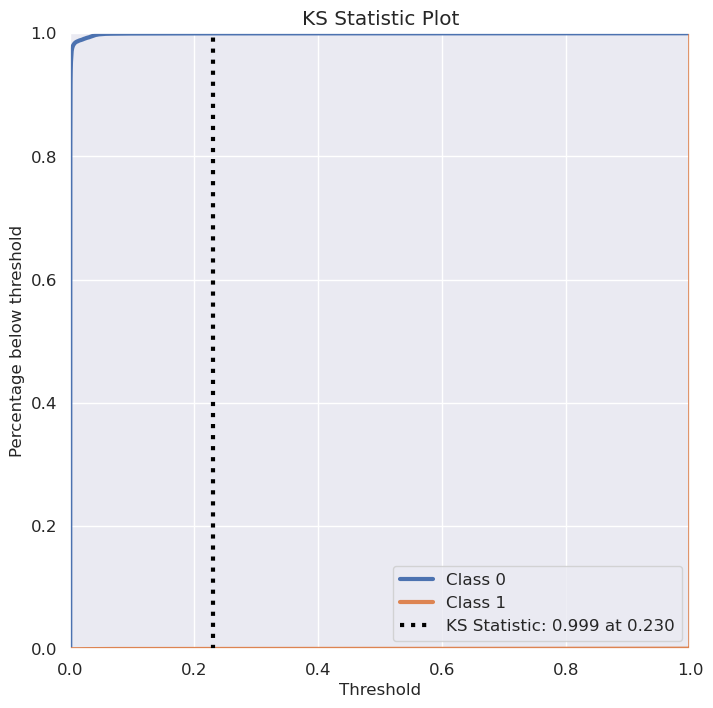

Results for distillation: Recall of 0.999366406893493; accuracy of 0.9994792557243009; precision of 0.9999260394104285; f1 of 0.9996461448271127; auroc of 0.9999945919608535; aupr of 0.9999980840056667


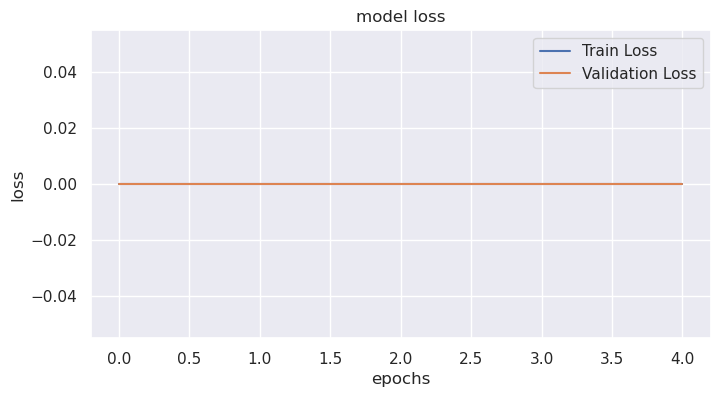

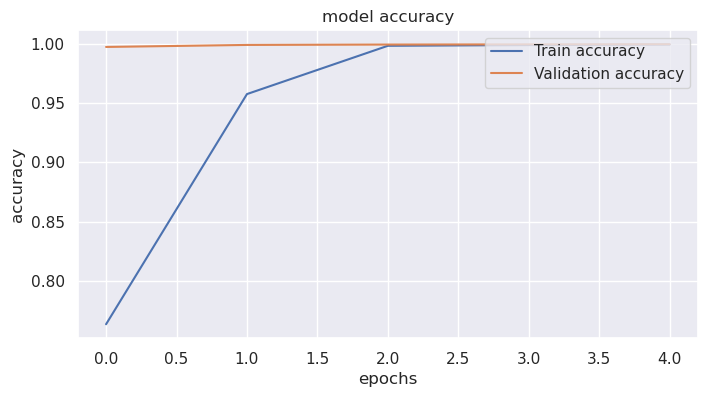

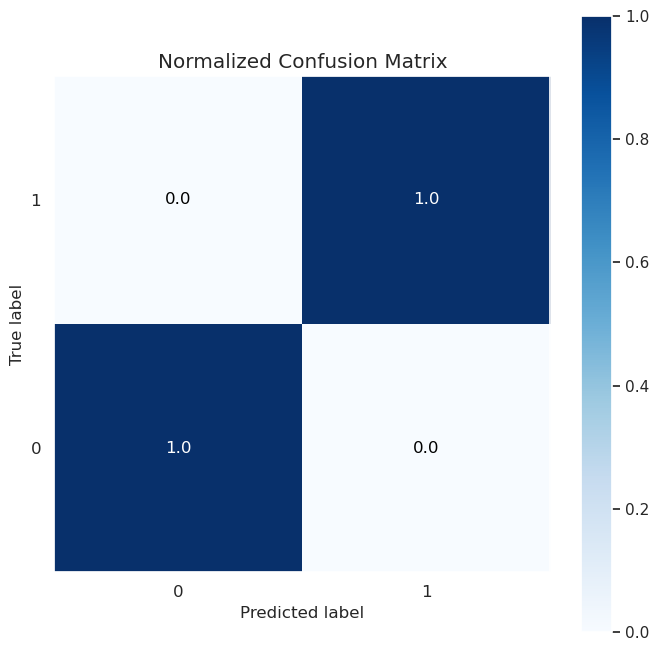

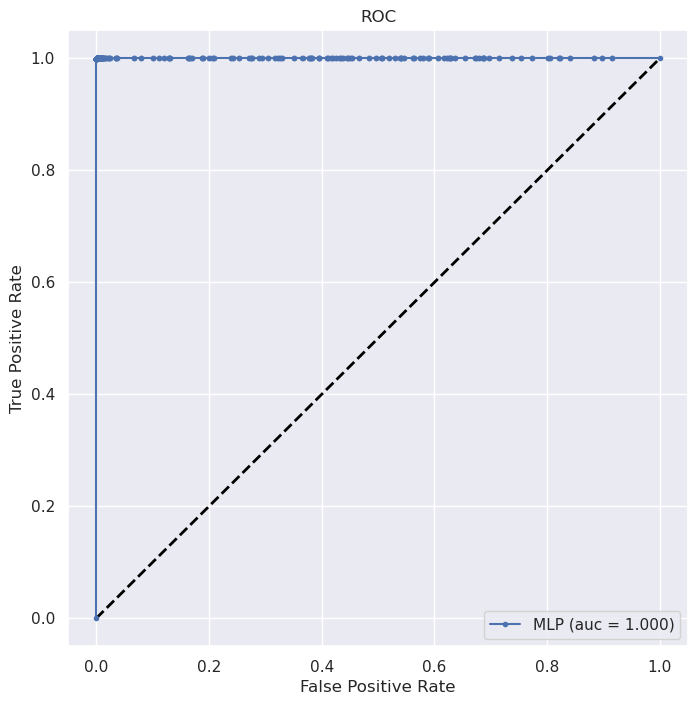

In [30]:
from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

save_path = '/home/pedro/projetoDL/distillation_log/exec1'

y_pred_scores = distillation_model.student_model.predict(x_val)
y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)


mseTeste = mean_squared_error(y_val, y_pred_class)

print(f'Results for distillation: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}')

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(save_path + "loss_and_val_loss.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['binary_accuracy'], label='Train accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(save_path + "loss_and_val_accuracy.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
subplot = skplt.metrics.plot_confusion_matrix(y_val, y_pred_class, normalize=True)
subplot.set_ylim(-0.5, 1.5)
plt.savefig(save_path + "conf_matrix.png")
plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(save_path + "plot_roc.png")
plt.show()

3. Ultra Light Student Model

4021/4021 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step


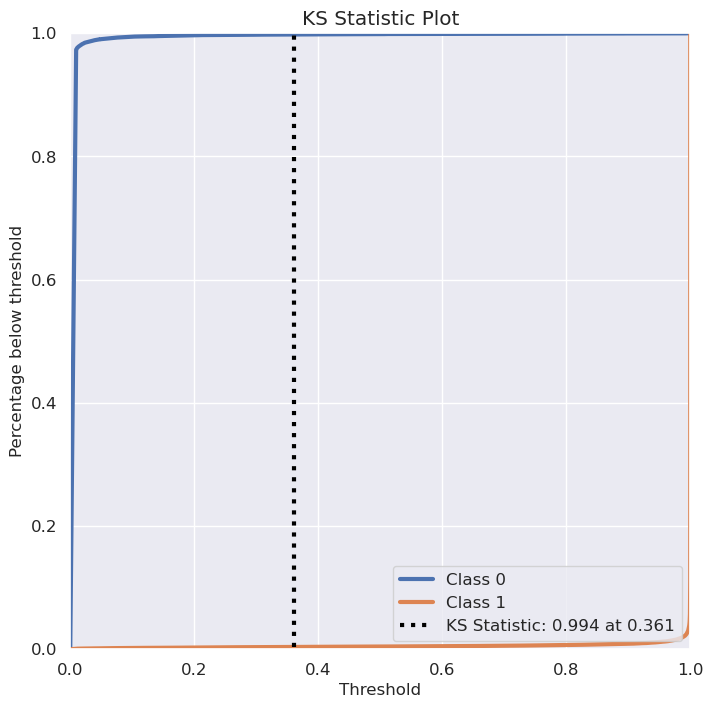

Results for distillation: Recall of 0.9955754081395595; accuracy of 0.9963781069779732; precision of 0.9995017280495303; f1 of 0.9975347045877773; auroc of 0.9995108782412068; aupr of 0.9997535611639173


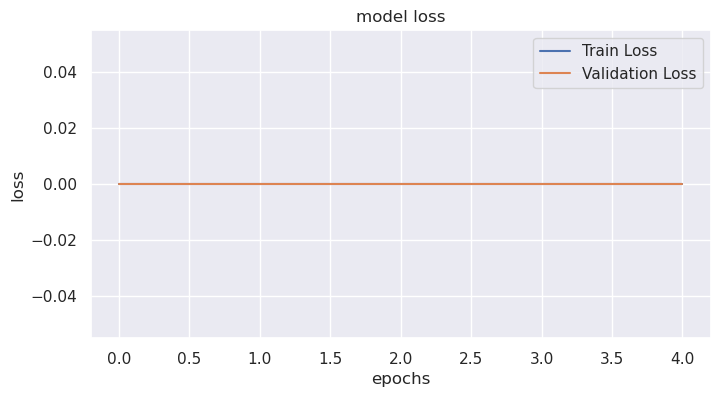

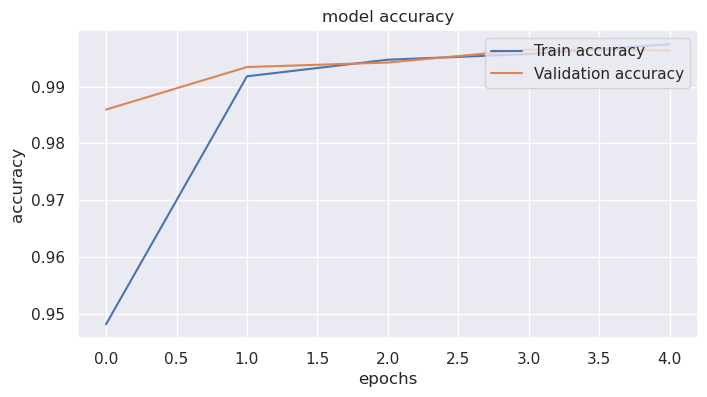

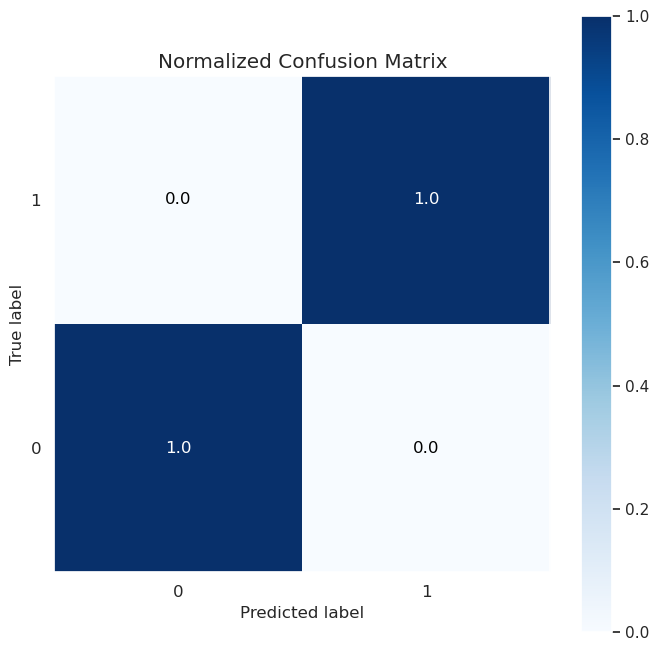

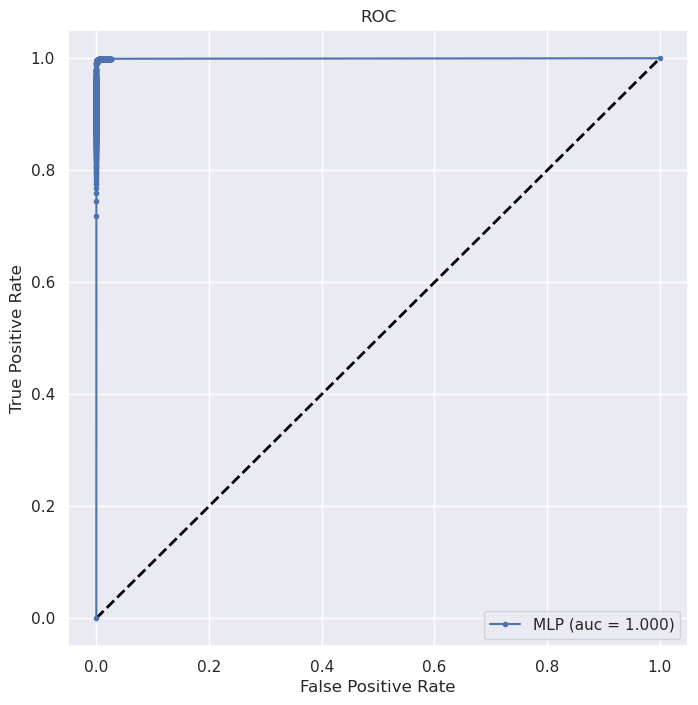

In [59]:
from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

save_path = '/home/pedro/projetoDL/distillation_log/ultra_light_student/'

y_pred_scores = ultra_light_distillation_model.student_model.predict(x_val)
y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)


mseTeste = mean_squared_error(y_val, y_pred_class)

print(f'Results for distillation: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}')

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(save_path + "loss_and_val_loss.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['binary_accuracy'], label='Train accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(save_path + "loss_and_val_accuracy.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
subplot = skplt.metrics.plot_confusion_matrix(y_val, y_pred_class, normalize=True)
subplot.set_ylim(-0.5, 1.5)
plt.savefig(save_path + "conf_matrix.png")
plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(save_path + "plot_roc.png")
plt.show()


# Student models - Evaluation in Test Data

In [61]:
path = "/home/pedro/projetoDL/dataset/processado/"

Y = np.load(path + 'Y_test_Driving_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_test_Driving_NewApproach_Injected_v2.npz')
X = X.f.arr_0

from sklearn.model_selection import train_test_split

# Definir 2/3 dos dados
X_test, _, Y_test, _ = train_test_split(
    X, Y, train_size=1/3, stratify=Y, random_state=42  # Stratify para manter a proporção de classes
)

In [62]:
del X, Y
gc.collect()

13217

19485/19485 ━━━━━━━━━━━━━━━━━━━━ 13s 650us/step


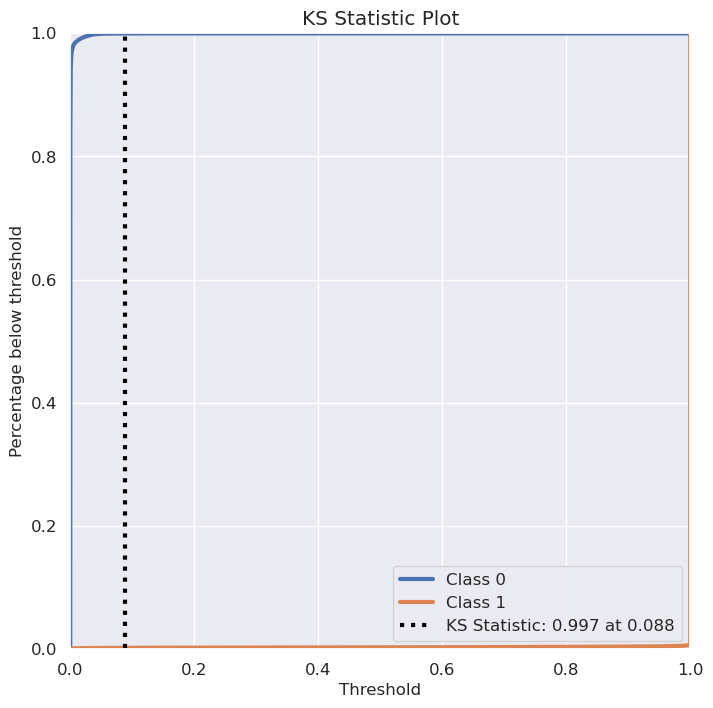

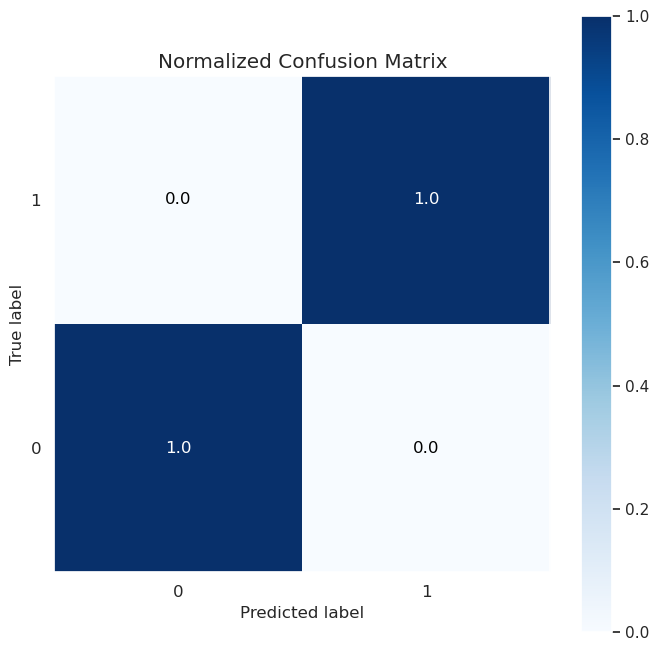

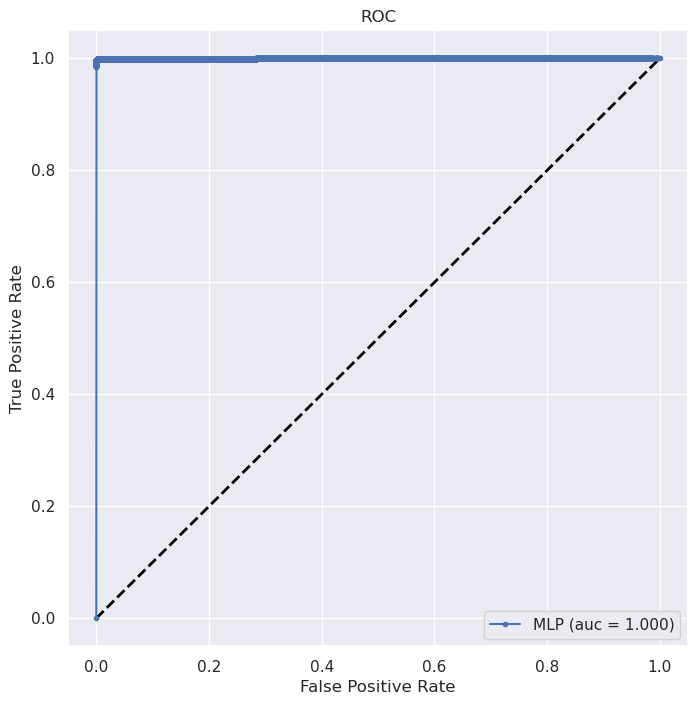

12414

In [67]:
from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time 

save_path = '/home/pedro/projetoDL/distillation_log/student_full/test_set/'
file1 = open(save_path + 'results_log.txt', "a")

if not os.path.exists(save_path):
    os.makedirs(save_path)

start = time.time()
y_pred_scores = distillation_model.student_model.predict(X_test)
end = time.time()
print(f"Runtime of the program is {end - start}", file=file1)

total_time = end - start
timesample = total_time/y_pred_scores.shape[0]

print(f"us/sample is {timesample*1000000}", file=file1)

y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(Y_test, y_pred_class, y_pred_scores)


mseTeste = mean_squared_error(Y_test, y_pred_class)

print(f'Results for distillation: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)


sns.set(rc={'figure.figsize':(8,8)})
subplot = skplt.metrics.plot_confusion_matrix(Y_test, y_pred_class, normalize=True)
subplot.set_ylim(-0.5, 1.5)
plt.savefig(save_path + "conf_matrix.png")
plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(save_path + "plot_roc.png")
plt.show()

file1.close()
gc.collect()

19485/19485 ━━━━━━━━━━━━━━━━━━━━ 12s 593us/step


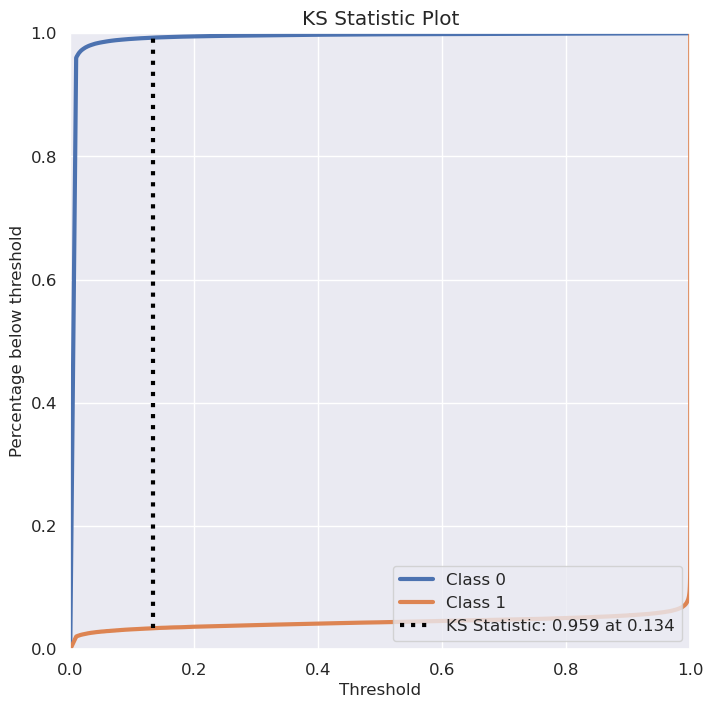

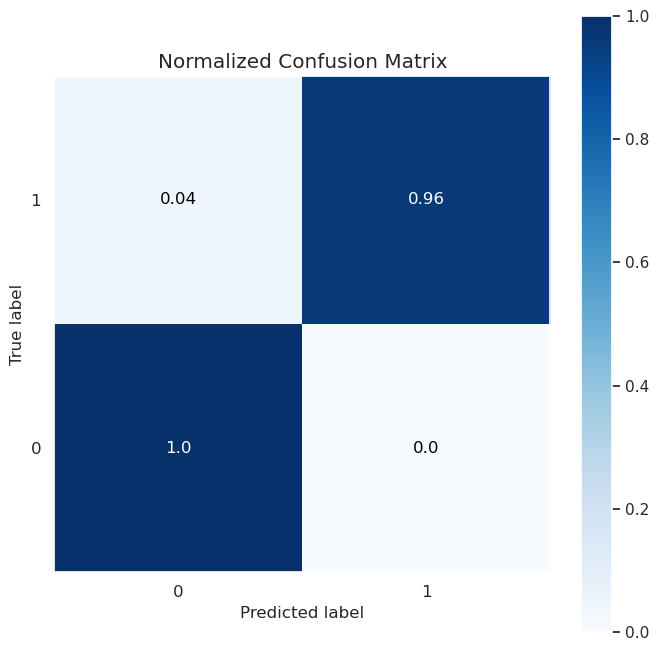

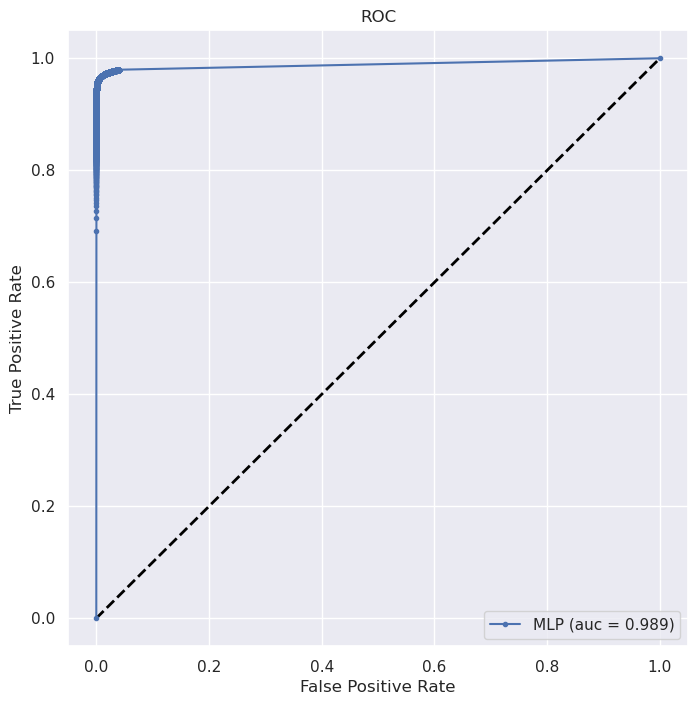

12430

In [66]:
from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

save_path = '/home/pedro/projetoDL/distillation_log/ultra_light_student/test_set/'
file1 = open(save_path + 'results_log.txt', "a")

if not os.path.exists(save_path):
    os.makedirs(save_path)

start = time.time()
y_pred_scores = ultra_light_distillation_model.student_model.predict(X_test)
end = time.time()
print(f"Runtime of the program is {end - start}", file=file1)

total_time = end - start
timesample = total_time/y_pred_scores.shape[0]

print(f"us/sample is {timesample*1000000}", file=file1)

y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(Y_test, y_pred_class, y_pred_scores)


mseTeste = mean_squared_error(Y_test, y_pred_class)

print(f'Results for distillation: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)


sns.set(rc={'figure.figsize':(8,8)})
subplot = skplt.metrics.plot_confusion_matrix(Y_test, y_pred_class, normalize=True)
subplot.set_ylim(-0.5, 1.5)
plt.savefig(save_path + "conf_matrix.png")
plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(save_path + "plot_roc.png")
plt.show()

file1.close()
gc.collect()